In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error


In [7]:
df = pd.read_csv("car_data.csv")  

print("Dataset Shape:", df.shape)
print(df.head())
print(df.info())
print(df.describe())


Dataset Shape: (301, 9)
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float

In [8]:
# Drop Car_Name
df = df.drop("Car_Name", axis=1)
# Create new feature: Car Age
df["Car_Age"] = 2020 - df["Year"] 
df.drop("Year", axis=1, inplace=True)
# One-Hot Encode categorical features
df = pd.get_dummies(df, drop_first=True)
print("Processed Columns:", df.columns)


Processed Columns: Index(['Selling_Price', 'Present_Price', 'Driven_kms', 'Owner', 'Car_Age',
       'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Selling_type_Individual',
       'Transmission_Manual'],
      dtype='object')


In [9]:
X = df.drop("Selling_Price", axis=1)
y = df["Selling_Price"]
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [18]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [20]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"{model_name}")
    print("R2 Score:", round(r2_score(y_true, y_pred), 4))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_true, y_pred)), 4))
    print("-" * 40)

evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")


Linear Regression
R2 Score: 0.8489
RMSE: 1.8658
----------------------------------------
Random Forest
R2 Score: 0.9621
RMSE: 0.9343
----------------------------------------


In [16]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV R2 Score:", round(grid.best_score_, 4))

best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
evaluate_model(y_test, y_pred_best_rf, "Tuned Random Forest")


Best Parameters: {'max_depth': 10, 'n_estimators': 200}
Best CV R2 Score: 0.8818
Tuned Random Forest
R2 Score: 0.9608
RMSE: 0.9497
----------------------------------------


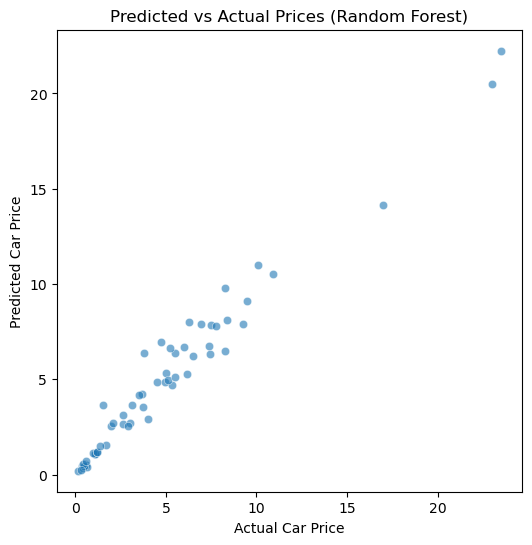

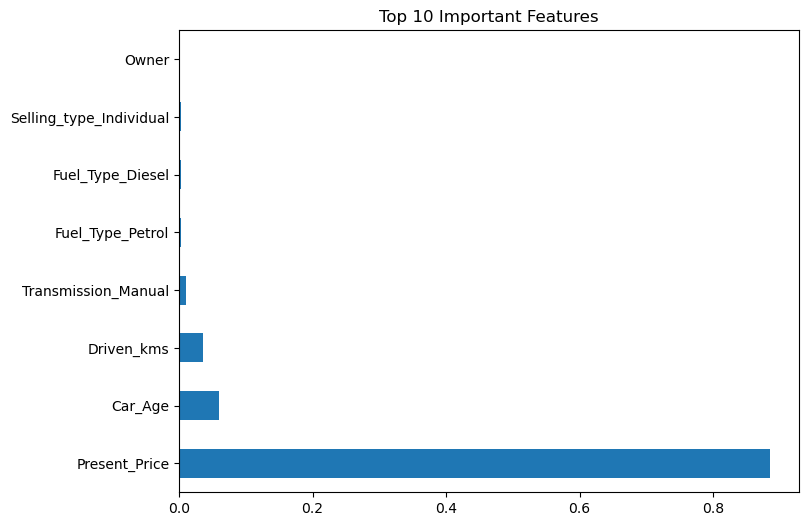

In [21]:
# Predicted vs Actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best_rf, alpha=0.6)
plt.xlabel("Actual Car Price")
plt.ylabel("Predicted Car Price")
plt.title("Predicted vs Actual Prices (Random Forest)")
plt.show()
# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh', figsize=(8,6))
plt.title("Top 10 Important Features")
plt.show()
